In [1]:
import pathlib
import numpy as np
from scipy import sparse
import sys
import os
import json
import matplotlib.pyplot as plt
from kneed import KneeLocator
from scipy.ndimage import uniform_filter1d

In [6]:
root_model_path = "/export/usuarios_ml4ds/lbartolome/Repos/umd/theta-evaluation/data/models/final_models/model-runs/wikitext-labeled/vocab_15k/k-50/"
bertopic_models = [
    "bertopic",
    "bertopic_approx",
]

In [3]:
for model in bertopic_models:
    print("###" * 50)
    print(f"-- -- Model: {model} -- --")
    with (pathlib.Path(root_model_path) / model / "tpc_descriptions.txt").open('r', encoding='utf8') as fin:
        tpc_descriptions = [el.strip() for el in fin.readlines()]
        for tpc, keys in enumerate(tpc_descriptions):
            print(f"Topic {tpc}: {keys}")
    print("\n")

######################################################################################################################################################
-- -- Model: bertopic -- --
Topic 0: film city years state known work war new including life century family public found government
Topic 1: album song chart video music band songs madonna single track pop vocals recording lyrics number
Topic 2: ship guns ships tons torpedo inch knots cruiser fleet deck gun turrets cruisers armament admiral
Topic 3: episode mulder scully doctor episodes files series viewers michael dwight television jim character season broadcast
Topic 4: tropical storm hurricane winds depression cyclone mph rainfall damage landfall wind utc flooding weakened intensity
Topic 5: innings yard runs team season league scored yards baseball nba touchdown wickets games coach batting
Topic 6: highway road route interchange intersection freeway east terminus north lane continues passes traffic avenue crosses
Topic 7: game player

In [4]:
def thrFig(thetas32, thetas_thr=3e-3, poly_degree=3, smoothing_window=5, do_knee=True):
    significant_docs = {}
    all_elbows = []

    # Calculate statistics
    min_val = thetas32.min()
    max_val = thetas32.max()
    mean_val = thetas32.mean()
    std_val = thetas32.std()
    percentiles = np.percentile(thetas32, [1, 25, 50, 75, 99])
    
    print(f"Statistics for Theta Values:")
    print(f"Min: {min_val}")
    print(f"Max: {max_val}")
    print(f"Mean: {mean_val}")
    print(f"Std Dev: {std_val}")
    print(f"Percentiles (1st, 25th, 50th, 75th, 99th): {percentiles}\n")
    
    num_topics = len(thetas32.T)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 3]})
    
    for k in range(num_topics):
        allvalues = np.sort(thetas32[:, k].flatten())
        step = int(np.round(len(allvalues) / 1000))
        x_values = allvalues[::step]
        y_values = (100 / len(allvalues)) * np.arange(0, len(allvalues))[::step]
        
        # Apply smoothing
        y_values_smooth = uniform_filter1d(y_values, size=smoothing_window)

        axs[0].semilogx(x_values, y_values_smooth, label=f'Topic {k+1}')
        
        if do_knee:
            # Using KneeLocator to find the elbow point
            kneedle = KneeLocator(x_values, y_values_smooth, curve='convex', direction='increasing', interp_method='polynomial', polynomial_degree=poly_degree)
            elbow = kneedle.elbow
            if elbow is not None:
                all_elbows.append(elbow)
                # Highlight the elbow point
                axs[0].scatter(elbow, kneedle.elbow_y, color='red', zorder=5, label=f'Elbow {k+1}')
                # Filter document indices based on the elbow point (keeping values above the elbow)
                significant_docs[k] = np.where(thetas32[:, k] >= elbow)[0]
    
    axs[0].set_title("Thetas - Elbows")
    axs[0].set_xlabel("Theta Value")
    axs[0].set_ylabel("Cumulative Percentage")
    #axs[0].legend()
    
    # HHistogram of theta values
    axs[1].hist(thetas32.ravel(), bins=50, color='blue', edgecolor='black', alpha=0.7)
    axs[1].set_title("Distribution of Theta Values")
    axs[1].set_xlabel("Theta Value")
    axs[1].set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()
        
    return significant_docs, all_elbows

--- WITH CUML---
Statistics for Theta Values:
Min: 2.984606619358172e-308
Max: 1.0
Mean: 0.013455950677599783
Std Dev: 0.058078241390158575
Percentiles (1st, 25th, 50th, 75th, 99th): [6.19244961e-308 1.73786050e-003 4.96655386e-003 1.03051378e-002
 1.70725170e-001]



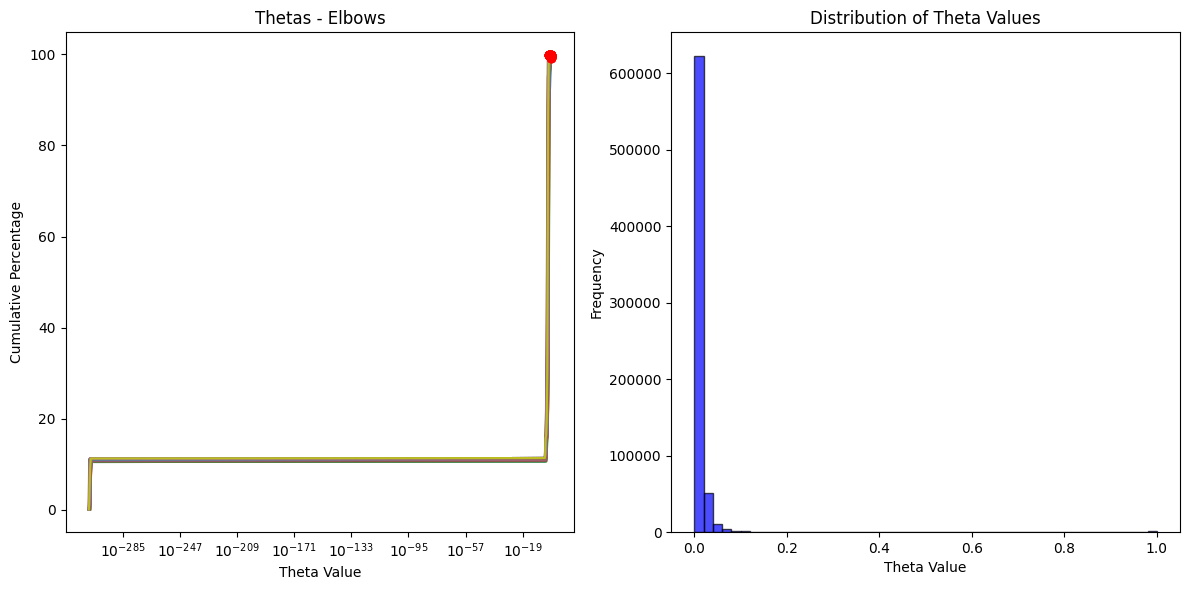


--- WITHOUT CUML (BERTOPIC DEFAULT)---
Statistics for Theta Values:
Min: 0.0
Max: 1.0049804160369846
Mean: 0.011500535553619629
Std Dev: 0.09931046933815288
Percentiles (1st, 25th, 50th, 75th, 99th): [5.16298702e-07 3.88220836e-05 9.55501611e-05 2.35806480e-04
 7.01439401e-01]



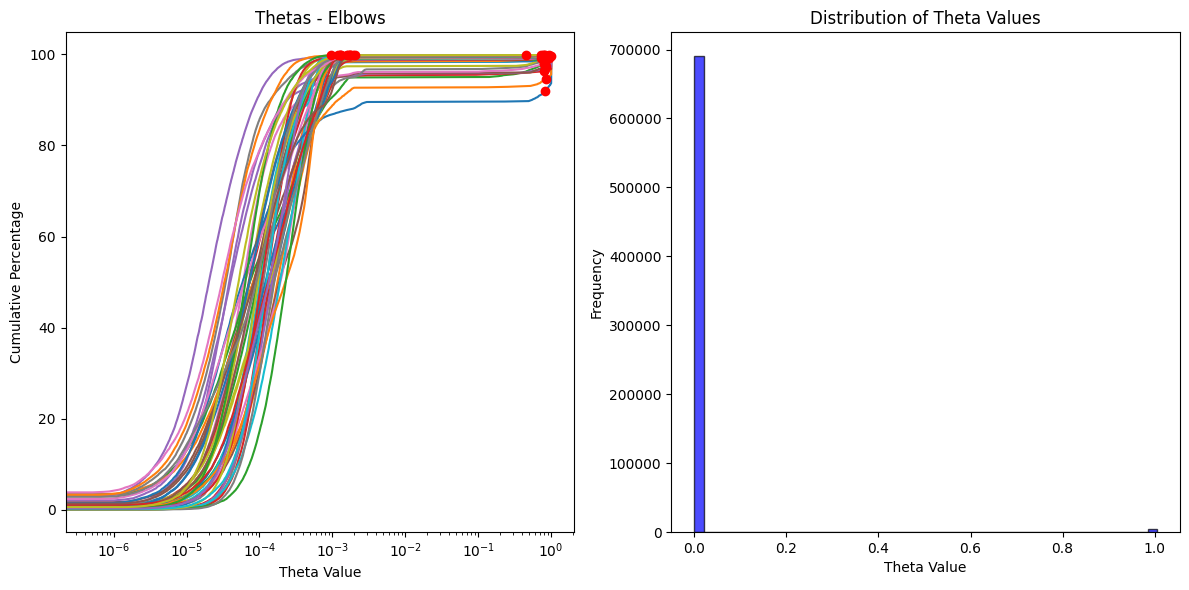

In [7]:
print("--- WITH CUML---")
significant_docs, elbows = thrFig(sparse.load_npz(pathlib.Path(root_model_path) / bertopic_models[0] / "thetas.npz").toarray())

print("\n--- WITHOUT CUML (BERTOPIC DEFAULT)---")
significant_docs, elbows = thrFig(sparse.load_npz(pathlib.Path(root_model_path) / bertopic_models[1] / "thetas.npz").toarray())